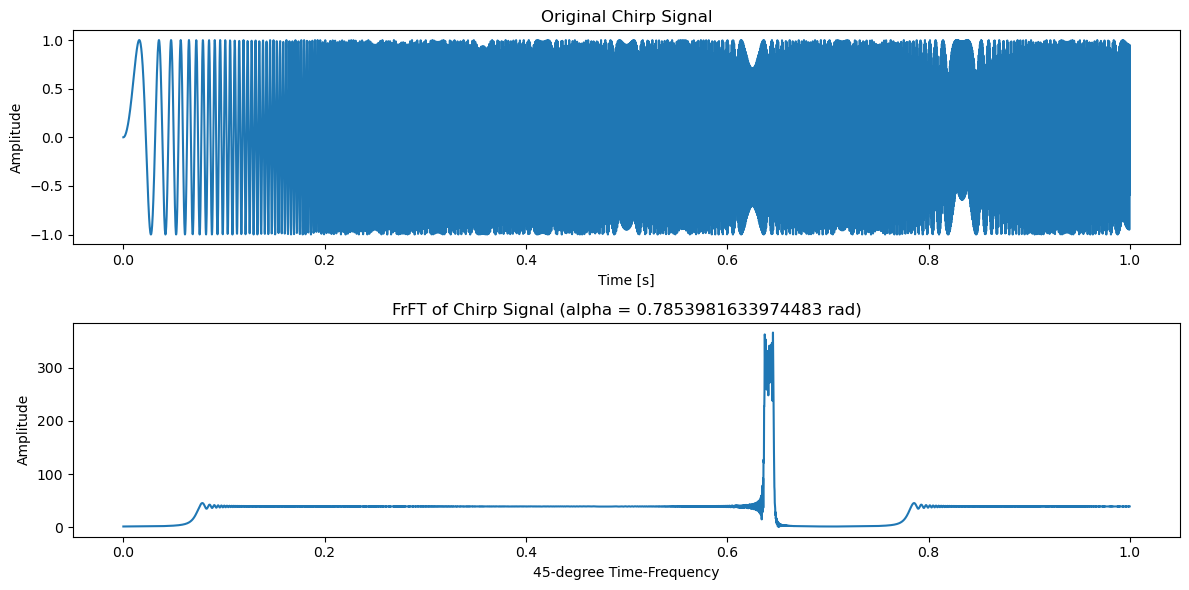

In [19]:
### Analysis of a Chirp Signal Using FrFT

import numpy as np
import matplotlib.pyplot as plt

def frft(signal, alpha):
    N = len(signal)
    n = np.arange(N)
    k = n.reshape((N, 1))

    # Handling special cases where sin(alpha) = 0
    if np.isclose(np.sin(alpha), 0):
        if np.isclose(alpha % (2 * np.pi), 0):  # Even multiples of π (identity operation)
            return signal
        elif np.isclose(alpha % (2 * np.pi), np.pi):  # Odd multiples of π (standard FT)
            return np.fft.fftshift(np.fft.fft(np.fft.fftshift(signal)))

    # Calculate the FrFT kernel for general cases
    M = np.exp(-1j * np.pi / N * (n - N//2) ** 2 * np.tan(alpha/2))
    M = M * np.exp(-1j * 2 * np.pi / N * (n - N//2) * (k - N//2) / np.sin(alpha))
    M = M * np.exp(-1j * np.pi / N * (k - N//2) ** 2 * np.tan(alpha/2))

    # Apply the FrFT
    transformed_signal = np.dot(M, signal)
    return transformed_signal

f0 = 0  # Start frequency
f1 = 1000  # End frequency
Fs = 5000  # Sampling frequency
duration = 1  # Duration in seconds
t = np.arange(0, duration, 1/Fs)  # Time vector from 0 to 1 second with step 1/Fs
# Make sure the length of t matches the length of chirp_signal
chirp_signal = np.sin(2 * np.pi * (f0 + (f1 - f0) * t) * t)

# Apply the FrFT to the chirp signal
#alpha = np.pi / 4  # Fractional order (45 degrees)
frft_signal = frft(chirp_signal, alpha)

# Plotting
plt.figure(figsize=(12, 6))

# Original Signal
plt.subplot(2, 1, 1)
plt.plot(t, chirp_signal)
plt.title("Original Chirp Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# FrFT of Signal
plt.subplot(2, 1, 2)
plt.plot(t, np.abs(frft_signal))
plt.title(f"FrFT of Chirp Signal (alpha = {alpha} rad)")
plt.xlabel("45-degree Time-Frequency")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


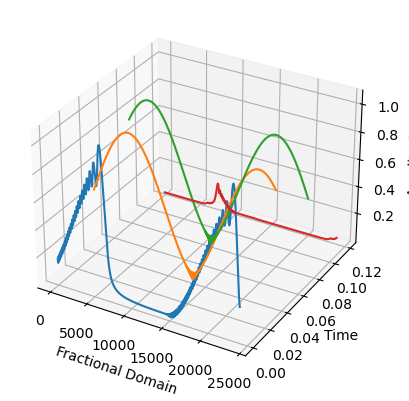

In [20]:
### Waterfall of FrFT

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.fftpack import fft, ifft

# Function to compute STFTs and apply FrFT to each segment
def stft_frft(signal, fs, window_size, overlap, alpha):
    f, t, Zxx = stft(signal, fs, nperseg=window_size, noverlap=overlap)
    frft_slices = np.array([frft(x, alpha) for x in Zxx.T])
    return f, t, frft_slices

# Function to plot the waterfall plot
def plot_waterfall(f, t, frft_slices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the waterfall plot
    for i, slice in enumerate(frft_slices):
        Y = np.full(slice.shape, t[i])
        ax.plot(f, Y, np.abs(slice))

    ax.set_xlabel('Fractional Domain')
    ax.set_ylabel('Time')
    ax.set_zlabel('Amplitude')
    plt.show()

# Example usage
fs = 48000  # Sampling frequency
window_size = 2000  # Size of each STFT segment
overlap = 100  # Overlap between segments
alpha = np.pi / 4  # FrFT alpha parameter

# Assuming 'signal' is your audio signal
f, t, frft_slices = stft_frft(chirp_signal, fs, window_size, overlap, alpha)
plot_waterfall(f, t, frft_slices)


In [ ]:
f0 = 0  # Start frequency
f1 = 1000  # End frequency
Fs = 5000  # Sampling frequency
duration = 1  # Duration in seconds
t = np.arange(0, duration, 1/Fs)  # Time vector from 0 to 1 second with step 1/Fs
# Make sure the length of t matches the length of chirp_signal
chirp_signal = np.sin(2 * np.pi * (f0 + (f1 - f0) * t) * t)

# Calculate FrFT for each alpha and Fourier Transform
alpha_range = np.linspace(0, 2 * np.pi, 1000)
frft_results = np.array([frft(chirp_signal, alpha) for alpha in alpha_range])
fourier_transform = np.fft.fftshift(np.fft.fft(chirp_signal))

# Frequency axis (assuming symmetry around zero frequency)
frequencies = np.linspace(-Fs/2, Fs/2, len(chirp_signal))

# Polar plot
plt.figure(figsize=(12, 6))
ax = plt.subplot(111, polar=True)

# Plot for each alpha
for idx, alpha in enumerate(alpha_range):
    # Map the amplitude to a color
    colors = plt.cm.viridis(np.abs(frft_results[idx])/np.max(np.abs(frft_results)))
    
    # Plot each frequency component
    for freq, color in zip(frequencies, colors):
        ax.plot([alpha, alpha], [0, freq], color=color, linewidth=1)

ax.set_ylim([-5000, 5000])  # Adjust frequency range
plt.title("Polar Colormap of FrFT across Fractional Orders")
plt.show()

Some things to consider is to use a fractional Fourier transform as the linear operator over which a Kalman filter is applied on each short-time slice. To avoid spectral leakage, it may be worthwhile to use some window before the FrFT that preserves total energy (Parseval's theorem apparently applies to FrFT in quarter rotations).

Some questions: What sorts of non-stationarity is FrFT useful for? What toy examples of useful impulse responses can be constructed? Considering Haar wavelets as derivative 